In [1]:
import re
import neologdn
import emoji
import urllib
import pandas as pd
from janome.tokenizer import Tokenizer
from nltk import ngrams, FreqDist, ConditionalFreqDist
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
import graphviz

In [2]:
# data
data_path = './data/shika.txt'
with open(data_path, 'r', encoding='utf_8') as f:
    data = [i.rstrip('\n') for i in f]

In [3]:
# stop word data
url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
urllib.request.urlretrieve(url, 'stop_word.txt')

with open('./stop_word.txt', 'r', encoding='utf_8') as f:
    stop_word = [i.rstrip('\n') for i in f]

In [4]:
# preprocessing
tmp = []
for line in data:
    line = neologdn.normalize(line)
    line = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', line)
    line = re.sub(r'[!-/:-@[-`{-~]', r' ', line)
    line = ''.join(['' if c in emoji.UNICODE_EMOJI else c for c in line])
    tmp.append(line)

data = tmp
del tmp

In [5]:
# morphological analysis
t = Tokenizer()
re_hiragana = re.compile(r'^[あ-ん]+$')
name = []
tokens = []

for line in data:
    tmp = []
    malist = t.tokenize(line)
    
    for word in malist:
        base, part = word.surface, word.part_of_speech
        
        # extract Meishi ^ not stop word
        if '名詞' in part and base not in stop_word:
            hiragana = re_hiragana.fullmatch(base) 
            
            # Hiragana (one character) or 'ー'
            if hiragana!=None and len(hiragana[0])==1 or base=='ー':
                continue
            
            tmp.append(base)
            tokens.append(base)
        
    name.append(tmp)

del tmp

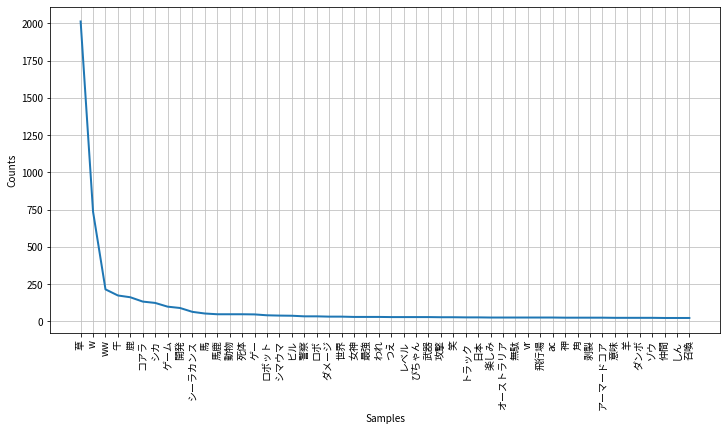

In [6]:
# plot word frequency
tokens_l = [word.lower() for word in tokens]
fd = FreqDist(tokens_l)
plt.figure(figsize=(12, 6))
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
fd.plot(50)
del tokens

In [7]:
# count custom words
custom_words = ['こんでろーん', 'おつでろーん']

for word in custom_words:
    
    cnt = 0
    for line in data:
        if re.findall(word + '.*', line) != []:
            cnt += 1

    print(word, cnt)

こんでろーん 71
おつでろーん 77


In [8]:
# calc bigram
bigram_list = []

for line in name:
    bigram = ngrams(line, 2)
    
    for bi in bigram:
        bigram_list.append(bi)

In [9]:
# calc conditional freq distribution
result = []
cfd = ConditionalFreqDist(bigram_list)

for key, values in cfd.items():
    
    for word, freq in values.items():
        result.append((key, word, freq))
        #result.append((key, word))

In [10]:
df = pd.DataFrame(result)
df.columns = ['word1', 'word2', 'intersection_count']

df_tmp = [[key, value] for key, value in Counter(tokens_l).items()]
df_tmp = pd.DataFrame(df_tmp)
df_tmp.columns = ['word', 'count']

In [11]:
df = pd.merge(df, df_tmp, left_on='word1', right_on='word', how='left').drop('word', axis=1)
df = pd.merge(df, df_tmp, left_on='word2', right_on='word', how='left').drop('word', axis=1)
df.columns = ['word1', 'word2', 'intersection_count', 'count1', 'count2']

In [12]:
# calc jaccard coefficient
df['union_count'] = df['count1'] + df['count2'] - df['intersection_count']
df['jaccard_coefficient'] = df['intersection_count'] / df['union_count']

In [13]:
df.head()

,word1,word2,intersection_count,count1,count2,union_count,jaccard_coefficient
0,夜,つまり,1,2.0,1.0,2.0,0.500000
1,夜,w,1,2.0,736.0,737.0,0.001357
2,つまり,ヨルシカ,1,1.0,2.0,2.0,0.500000
3,究極,バカゲー,1,1.0,13.0,13.0,0.076923
4,ビリ,ビリ,1,2.0,2.0,3.0,0.333333


In [14]:
# ref. https://www.dskomei.com/entry/2019/04/07/021028

def plot_network(data, edge_threshold, random_state):

    plt.figure(figsize=(15, 15))
    G = nx.Graph()
    
    # node
    nodes = list(set(data['word1'].tolist() + data['word2'].tolist()))
    G.add_nodes_from(nodes)
    
    # edge
    for i in range(len(data)):
        row_data = data.iloc[i]
        if row_data['jaccard_coefficient'] > edge_threshold:
            G.add_edge(row_data['word1'], row_data['word2'], weight=row_data['jaccard_coefficient'])

    # remove independent nodes
    isolated = [n for n in G.nodes if len([i for i in nx.all_neighbors(G, n)]) == 0]
    for n in isolated:
        G.remove_node(n)
        
    # adjust layout
    #pos = nx.spring_layout(G, k=0.3, seed=42)
    pos = nx.nx_agraph.graphviz_layout(
        G,
        prog='neato',
        args='-Goverlap="scalexy" -Gsep="+6" -Gnodesep=0.8 -Gsplines="polyline" -GpackMode="graph" -Gstart={}'.format(random_state)
    )
    
    pr = nx.pagerank(G)
    nx.draw_networkx_nodes(G, pos, node_color=list(pr.values()), cmap=plt.cm.Reds, alpha=0.7, node_size=[60000*v for v in pr.values()])
    edge_width = [d['weight'] * 100 for (u, v, d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='darkgrey', width=edge_width)
    nx.draw_networkx_labels(G, pos, fontsize=14, font_family='Noto Sans CJK JP', font_weight='bold')
    
    plt.axis('off')
    plt.savefig('./collocation_network.png')
    plt.show()

In [15]:
n_word_lower = 20
edge_threshold = 0.01
random_state = 42
df = df.sort_values('jaccard_coefficient', ascending=False)
df = df[(df['count1'] >= n_word_lower) & (df['count2'] >= n_word_lower)]

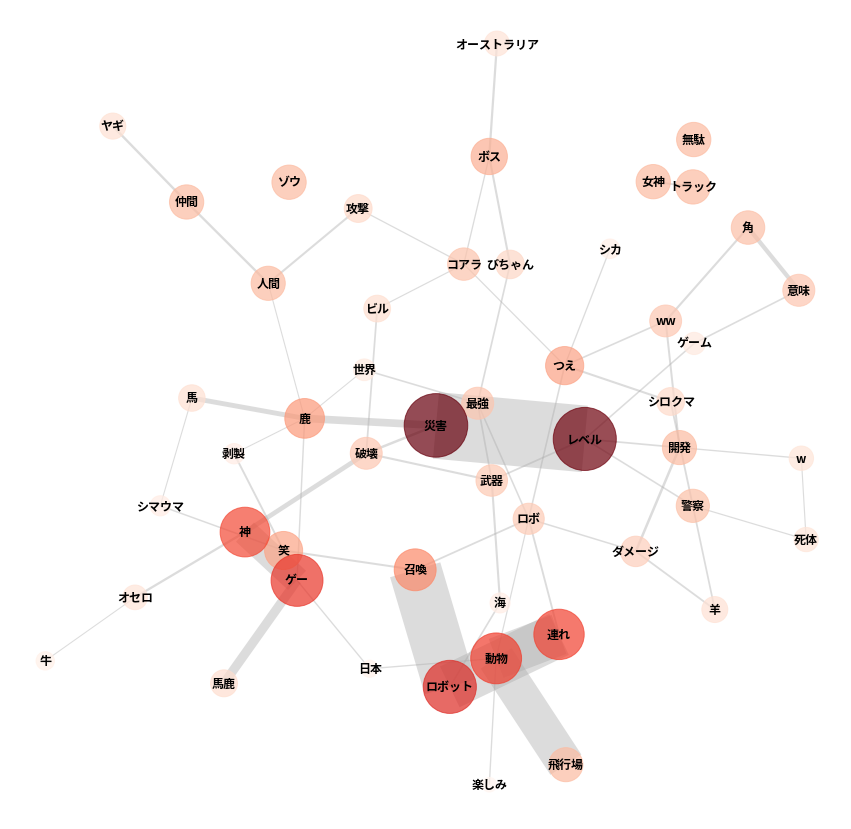

In [16]:
plot_network(df, edge_threshold, random_state)